In [3]:
from functools import partial
import operator
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.base import (BaseEstimator, 
                          ClassifierMixin)
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import (ConvergenceWarning, 
                                UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             f1_score,
                             make_scorer,
                             precision_score, 
                             recall_score, 
                             roc_curve)
from sklearn.model_selection import (cross_val_score, 
                                     GridSearchCV,
                                     learning_curve, 
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import (LinearSVC, 
                         SVC)
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

In [4]:
cwd = Path.cwd()
pkl_path = cwd / 'data' / 'audio_df.pkl'

In [5]:
audio_df = pd.read_pickle(pkl_path)

In [6]:
audio_df.shape

(2121, 69)

In [7]:
audio_df.head()

,song,seg,tempo,dynamic_tempo_mean,dynamic_tempo_median,dynamic_tempo_std,dynamic_tempo_amin,dynamic_tempo_amax,pitch_0_mean,pitch_0_median,...,pitch_10_median,pitch_10_std,pitch_10_amin,pitch_10_amax,pitch_11_mean,pitch_11_median,pitch_11_std,pitch_11_amin,pitch_11_amax,artist
0,21StCentury,0,117.453835,116.845143,117.453835,1.654658e+00,112.347147,117.453835,0.427060,0.404514,...,0.308261,0.308046,0.112909,1.0,0.356015,0.334299,0.150156,0.061158,0.763258,RedHotChiliPeppers
1,21StCentury,1,117.453835,116.818981,117.453835,2.229267e+00,112.347147,123.046875,0.451266,0.422953,...,0.351420,0.274104,0.117207,1.0,0.330460,0.330812,0.096484,0.178364,0.619085,RedHotChiliPeppers
2,21StCentury,2,117.453835,120.001509,117.453835,1.081003e+01,112.347147,161.499023,0.431115,0.397945,...,0.350978,0.311283,0.165567,1.0,0.348092,0.311502,0.113781,0.189196,0.622813,RedHotChiliPeppers
3,21StCentury,3,117.453835,119.821786,117.453835,7.041619e+00,117.453835,161.499023,0.433209,0.386246,...,0.353645,0.272296,0.121033,1.0,0.316156,0.297740,0.109587,0.107098,0.536942,RedHotChiliPeppers
4,21StCentury,4,117.453835,117.453835,117.453835,1.421085e-14,117.453835,117.453835,0.433089,0.316087,...,0.213566,0.213278,0.074096,1.0,0.219393,0.200609,0.135975,0.047603,0.585161,RedHotChiliPeppers


In [8]:
X = audio_df.drop(columns=['song', 'seg', 'artist'])
y = audio_df['artist'].map({'Eminem': 0, 'RedHotChiliPeppers': 1})

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
metric_scores = [accuracy_score, f1_score, precision_score, recall_score]
metric_names = [metric.__name__ for metric in metric_scores]

In [11]:
class BaselineClassifier(BaseEstimator, ClassifierMixin):
    """A classifier that always predicts the baseline class."""
    
    def __init__(self, baseline=None):
        self.baseline = baseline
    
    def fit(self, X=None, y=None):
        return
    
    def predict(self, X):
        return np.full(len(X), self.baseline)

In [12]:
EminemClassifier = BaselineClassifier(0)
RHCPClassifier = BaselineClassifier(1)

In [13]:
def cv_score(estimator, X, y, cv=5, scoring=None):
    """Return the mean score of an estimator and classifier objects X and y using cross validation."""
    
    cvs = cross_val_score(estimator=estimator, 
                          X=X, 
                          y=y, 
                          cv=cv,
                          scoring=scoring)
    return cvs.mean()

In [14]:
cv_X_y = partial(cv_score, X=X, y=y)
cv_accuracy = partial(cv_X_y, scoring=make_scorer(accuracy_score))
cv_f1 = partial(cv_X_y, scoring=make_scorer(f1_score))
cv_precision = partial(cv_X_y, scoring=make_scorer(precision_score))
cv_recall = partial(cv_X_y, scoring=make_scorer(recall_score))

cv_metrics = [cv_accuracy, cv_f1, cv_precision, cv_recall]

In [15]:
def score_estimator(estimator):
    return {name: cv(estimator) for name, cv in zip(metric_names, cv_metrics)}

In [16]:
def plot_roc_calc_auc(estimator, X_train, X_test, y_train, y_test):
    """Plot the ROC and return the AUC."""
    
    estimator.fit(X_train, y_train)
    y_score = estimator.predict_proba(X_test)
    false_pos, true_pos, _ = roc_curve(y_test, y_score[:,1])
    
    plt.plot(false_pos, true_pos)
    
    est_name = type(estimator).__name__
    default_params = type(estimator)().get_params().items()
    estimator_params = estimator.get_params().items()
    hyper_params = (est_p for def_p, est_p in zip(default_params, estimator_params) if def_p != est_p)
    hyper_params = (f'{arg}={val}' for arg, val in hyper_params)
    hyper_params = ', '.join(hyper_params)
    
    plt.title(f'ROC: {est_name}({hyper_params})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    return f'AUC: {auc(false_pos, true_pos)}'

In [17]:
plot_roc_calc_auc_audio = partial(plot_roc_calc_auc, 
                                  X_train=X_train,
                                  X_test=X_test,
                                  y_train=y_train,
                                  y_test=y_test)

# Baselines

In [16]:
score_estimator(EminemClassifier)

{'accuracy_score': 0.4507302996670366,
 'f1_score': 0.0,
 'precision_score': 0.0,
 'recall_score': 0.0}

In [17]:
score_estimator(RHCPClassifier)

{'accuracy_score': 0.5492697003329634,
 'f1_score': 0.7090690390602953,
 'precision_score': 0.5492697003329634,
 'recall_score': 1.0}

# KNN

In [18]:
param_grid = {'n_neighbors': range(1, 21)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5)
grid.fit(X, y)
knn_best = grid.best_params_
knn_best

{'n_neighbors': 3}

In [19]:
knn_best

{'n_neighbors': 3}

In [20]:
score_estimator(KNeighborsClassifier(**knn_best))

{'accuracy_score': 0.6416681465038846,
 'f1_score': 0.6792402741364173,
 'precision_score': 0.6714782045516154,
 'recall_score': 0.690128755364807}

'AUC: 0.7594624860022396'

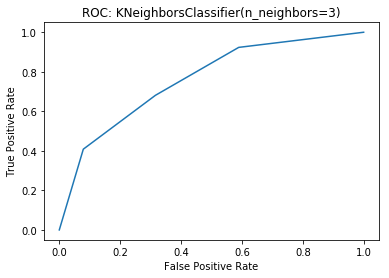

In [21]:
plot_roc_calc_auc_audio(KNeighborsClassifier(**knn_best))

# Logistic Regression

In [22]:
param_grid = {'C': [pow(10, i) for i in range(-3, 4)], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)
grid.fit(X, y)
logreg_best = grid.best_params_
logreg_best

{'C': 1, 'penalty': 'l2'}

In [23]:
score_estimator(LogisticRegression(**logreg_best))

{'accuracy_score': 0.7293562708102108,
 'f1_score': 0.7658774423422235,
 'precision_score': 0.733990286511349,
 'recall_score': 0.8051502145922746}

'AUC: 0.8507502799552071'

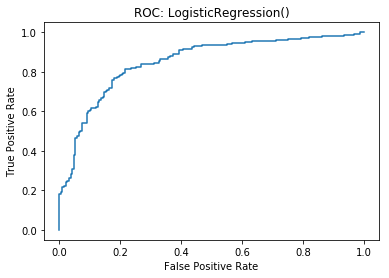

In [24]:
plot_roc_calc_auc_audio(LogisticRegression(**logreg_best))

# Gaussian Naive Bayes

In [25]:
score_estimator(GaussianNB())

{'accuracy_score': 0.6926215316315206,
 'f1_score': 0.7405519952085428,
 'precision_score': 0.6946425557183566,
 'recall_score': 0.7974248927038626}

'AUC: 0.8073236282194849'

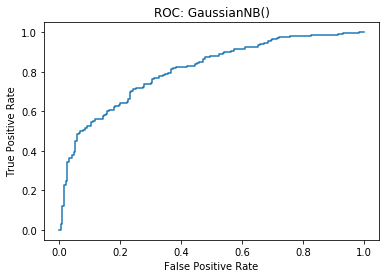

In [26]:
plot_roc_calc_auc_audio(GaussianNB())

# Linear SVC

In [27]:
score_estimator(LinearSVC())

{'accuracy_score': 0.6096415094339622,
 'f1_score': 0.5506318467306538,
 'precision_score': 0.7594502080731643,
 'recall_score': 0.8369098712446352}

# SVC

In [ ]:
#: Too slow... run overnight?

# param_grid = {'kernel': ['poly', 'rbf', 'precomputed', 'sigmoid']}
# grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
# grid.fit(X, y)
# svc_best = grid.best_params_
# svc_best

In [28]:
score_estimator(SVC())

{'accuracy_score': 0.6473362930077691,
 'f1_score': 0.6808410270837189,
 'precision_score': 0.6835264790022956,
 'recall_score': 0.6824034334763949}

'AUC: 0.7664837625979843'

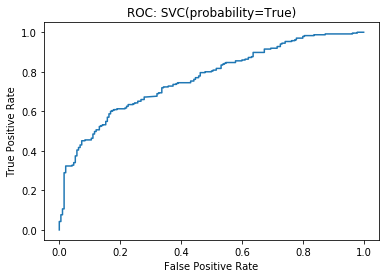

In [29]:
plot_roc_calc_auc_audio(SVC(probability=True))

# Decision Tree

In [21]:
param_grid = {'criterion': ['gini', 'entropy']}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid.fit(X, y)
dectree_best = grid.best_params_
dectree_best

{'criterion': 'gini'}

In [25]:
score_estimator(DecisionTreeClassifier(**dectree_best))

{'accuracy_score': 0.6708923418423973,
 'f1_score': 0.7194297784423733,
 'precision_score': 0.6690613915091113,
 'recall_score': 0.7648068669527897}

'AUC: 0.8173012318029115'

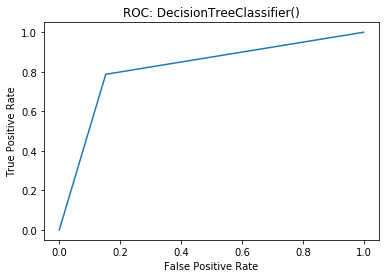

In [26]:
plot_roc_calc_auc_audio(DecisionTreeClassifier(**dectree_best))

# Random Forest

In [27]:
param_grid = {'criterion': ['gini', 'entropy']}
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X, y)
randforest_best = grid.best_params_
randforest_best

{'criterion': 'entropy'}

In [28]:
score_estimator(RandomForestClassifier(**randforest_best))

{'accuracy_score': 0.7364428412874584,
 'f1_score': 0.7689503275034921,
 'precision_score': 0.7467092079003141,
 'recall_score': 0.8163090128755364}

'AUC: 0.9693952967525197'

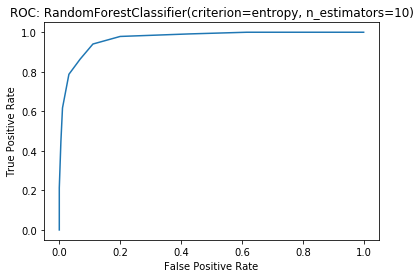

In [29]:
plot_roc_calc_auc_audio(RandomForestClassifier(**randforest_best))